In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
#empty gpu cache
torch.cuda.empty_cache()

In [2]:
# Load CoNLL dataset from Hugging Face
dataset = load_dataset('conll2003')

# Build vocabulary for tokens and labels
token2idx = {'<PAD>': 0, '<UNK>': 1}  # Special tokens for padding and unknown words
unique_labels = set(label for example in dataset['train']['ner_tags'] for label in example)
label2idx = {label: i for i, label in enumerate(sorted(unique_labels))}
idx2label = {i: label for label, i in label2idx.items()}

# Populate token2idx with tokens from the dataset
all_tokens = set(token for example in dataset['train']['tokens'] for token in example)
token2idx.update({token: i + 2 for i, token in enumerate(sorted(all_tokens))})  # Offset by 2 for special tokens

In [3]:
# Model configuration
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = len(unique_labels)
PAD_IDX = token2idx['<PAD>']

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Custom Dataset class
class NERDataset(Dataset):
    def __init__(self, data, token2idx, label2idx):
        self.inputs = [[token2idx.get(token, token2idx['<UNK>']) for token in tokens] for tokens in data['tokens']]
        self.labels = [[label2idx[label] for label in labels] for labels in data['ner_tags']]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx])

# Pad sequences for batch training
def collate_fn(batch):
    tokens, labels = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=PAD_IDX)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Ignore index for loss calculation
    return tokens_padded.to(device), labels_padded.to(device)
# Prepare data loaders
train_dataset = NERDataset(dataset['train'], token2idx, label2idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
vocab_size = len(token2idx)

In [6]:
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out)
        return logits

In [7]:
# Instantiate model
model = BiLSTM_NER(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding labels in loss calculation


Epoch 1, Loss: 0.2788, Accuracy: 0.9224, Precision: 0.7858, Recall: 0.6229, F1-Score: 0.6908
Epoch 2, Loss: 0.0677, Accuracy: 0.9803, Precision: 0.9177, Recall: 0.8968, F1-Score: 0.9070
Epoch 3, Loss: 0.0287, Accuracy: 0.9916, Precision: 0.9606, Recall: 0.9523, F1-Score: 0.9564
Epoch 4, Loss: 0.0170, Accuracy: 0.9951, Precision: 0.9760, Recall: 0.9720, F1-Score: 0.9740
Epoch 5, Loss: 0.0115, Accuracy: 0.9964, Precision: 0.9813, Recall: 0.9793, F1-Score: 0.9803


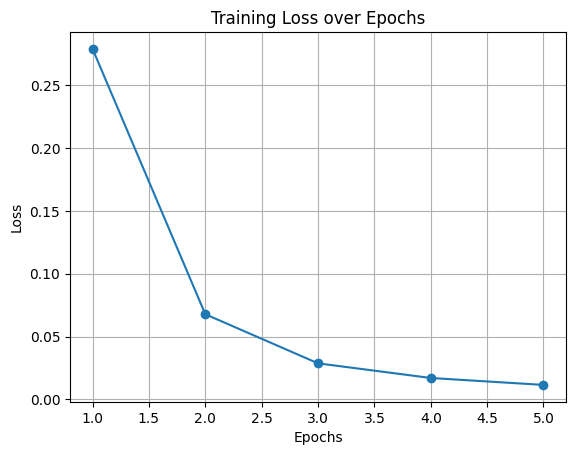

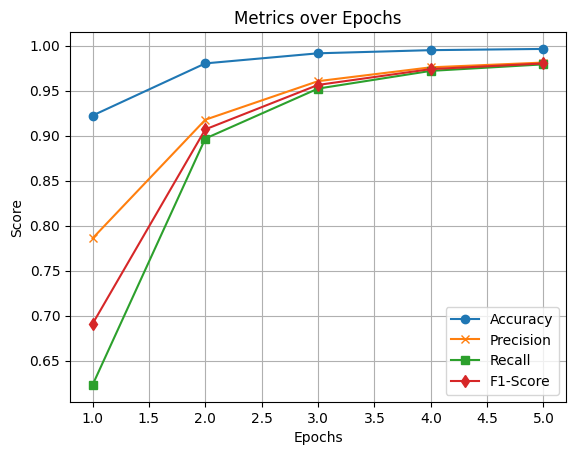

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

# Initialize lists to store losses and metrics
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

def train_model():
    model.train()
    for epoch in range(5):  # Number of epochs
        epoch_loss = 0
        all_preds = []
        all_labels = []
        
        for tokens, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(tokens)  # outputs shape: (batch_size, seq_len, NUM_CLASSES)
            loss = criterion(outputs.view(-1, NUM_CLASSES), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Get predictions
            preds = outputs.argmax(dim=-1)  # shape: (batch_size, seq_len)

            # Move tensors to CPU and flatten
            preds_flat = preds.view(-1).cpu().numpy()
            labels_flat = labels.view(-1).cpu().numpy()

            # Exclude PAD_LABEL
            mask = labels_flat != -100
            masked_preds = preds_flat[mask]
            masked_labels = labels_flat[mask]

            # Collect the predictions and labels
            all_preds.extend(masked_preds)
            all_labels.extend(masked_labels)

        # Convert lists to numpy arrays
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Compute metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        # Store metrics
        loss_values.append(epoch_loss / len(train_loader))
        accuracy_values.append(acc)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Plot loss graph
    plt.figure()
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.show()

    # Plot accuracy graph
    plt.figure()
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run training
train_model()

In [9]:
from TorchCRF import CRF
import torch.optim as optim
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)
        self.crf = CRF(num_classes, batch_first=True)

    def forward(self, sentences, labels=None):
        embeds = self.embedding(sentences)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)
        
        if labels is not None:
            # Determine valid positions for the CRF loss based on padding
            mask = labels != -100
            # Instead of the full mask calculation during scoring, this mask ensures correct label indices.
            valid_labels = torch.where(labels >= 0, labels, torch.zeros_like(labels))
            
            crf_loss = -self.crf(emissions, valid_labels, mask=mask)
            return crf_loss
        else:
            # For decoding, use mask based on sentence padding
            mask = sentences != PAD_IDX
            return self.crf.decode(emissions, mask=mask)

# Instantiate the model
model = BiLSTM_CRF(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, PAD_IDX).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Loss: 253.4506, Accuracy: 0.8592, Precision: 0.5895, Recall: 0.2632, F1-Score: 0.3315
Epoch 2, Loss: 100.1972, Accuracy: 0.9374, Precision: 0.8435, Recall: 0.6688, F1-Score: 0.7401
Epoch 3, Loss: 51.8361, Accuracy: 0.9695, Precision: 0.9138, Recall: 0.8370, F1-Score: 0.8724
Epoch 4, Loss: 26.7771, Accuracy: 0.9864, Precision: 0.9588, Recall: 0.9252, F1-Score: 0.9414
Epoch 5, Loss: 13.1095, Accuracy: 0.9949, Precision: 0.9829, Recall: 0.9707, F1-Score: 0.9767


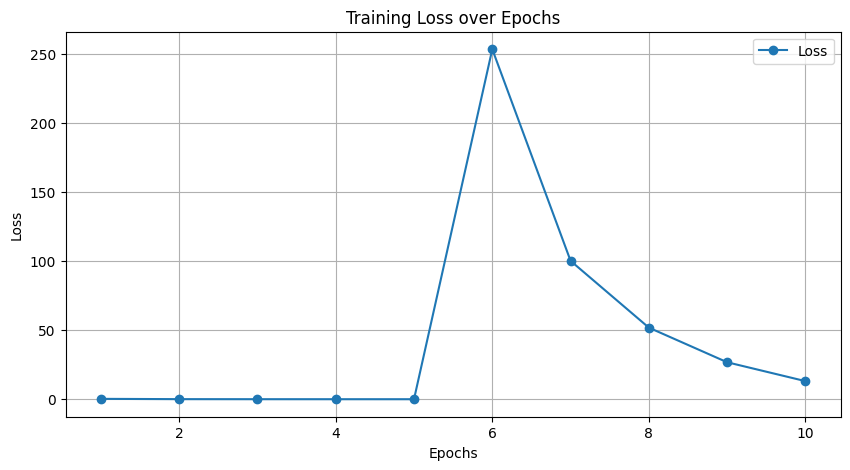

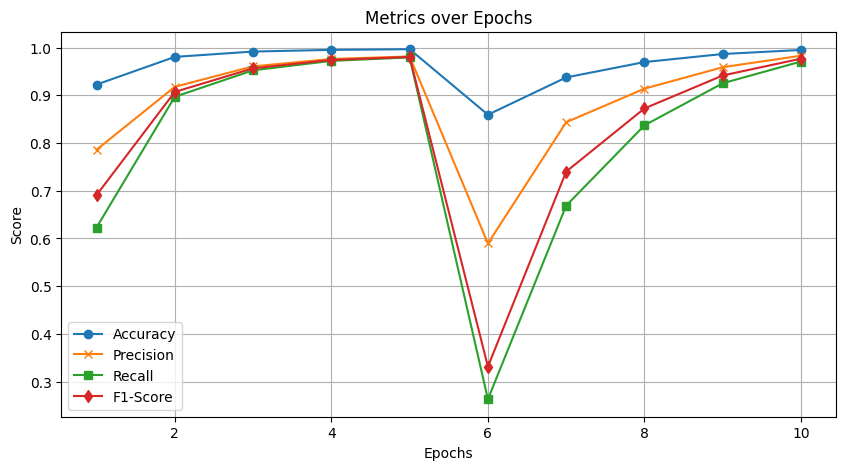

In [10]:
def train_model():
    model.train()
    for epoch in range(5):  # Number of epochs
        epoch_loss = 0
        all_preds, all_labels = [], []
        
        for tokens, labels in train_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            optimizer.zero_grad()
            
            try:
                loss = model(tokens, labels=labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            except Exception as e:
                print(f"Exception: {e}")
                print(f"Tokens: {tokens.shape}, Labels: {labels.shape}")
                print(f"Sample Tokens: {tokens[0]}, Sample Labels: {labels[0]}")
                return
            
            # Get predictions using CRF decode
            preds = model(tokens)  # Decoded predictions
            
            # Collect predictions and true labels for evaluation
            for i in range(len(preds)):
                seq_len = (labels[i] != -100).sum().item()
                all_preds.extend(preds[i][:seq_len])  # Only valid token predictions
                all_labels.extend(labels[i][:seq_len].cpu().numpy())

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        # Store metrics for plotting
        loss_values.append(epoch_loss / len(train_loader))
        accuracy_values.append(acc)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Plot loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot accuracy and metrics graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

try:
    train_model()
except Exception as e:
    print(e)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [15]:
# Load the CoNLL 2003 dataset
dataset = load_dataset('conll2003')

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

# Define a function to tokenize the input examples
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding='max_length', max_length=128)
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize and align labels
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [20]:
class NERDataset(Dataset):
    def __init__(self, dataset):
        self.encodings = {
            'input_ids': dataset['input_ids'],
            'attention_mask': dataset['attention_mask'],
            'labels': dataset['labels']
        }

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Prepare DataLoader
train_dataset = NERDataset(tokenized_datasets['train'])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [21]:
print(tokenized_datasets['train'])

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 14041
})


In [22]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(dataset['train'].features['ner_tags'].feature.names))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

e:\ML\ML\.env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Loss: 0.1199, Accuracy: 0.9148, Precision: 0.7898, Recall: 0.7512, F1-Score: 0.7673


e:\ML\ML\.env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Loss: 0.0468, Accuracy: 0.9358, Precision: 0.8498, Recall: 0.8500, F1-Score: 0.8497
Epoch 3, Loss: 0.0295, Accuracy: 0.9407, Precision: 0.8660, Recall: 0.8703, F1-Score: 0.8680


e:\ML\ML\.env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


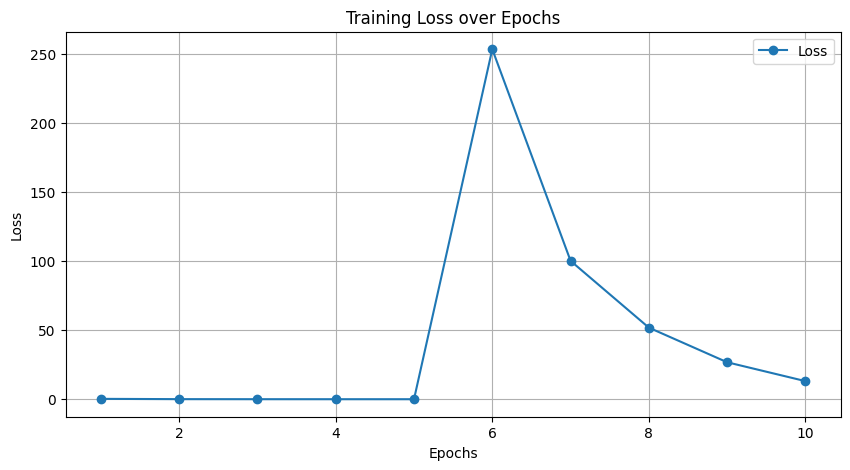

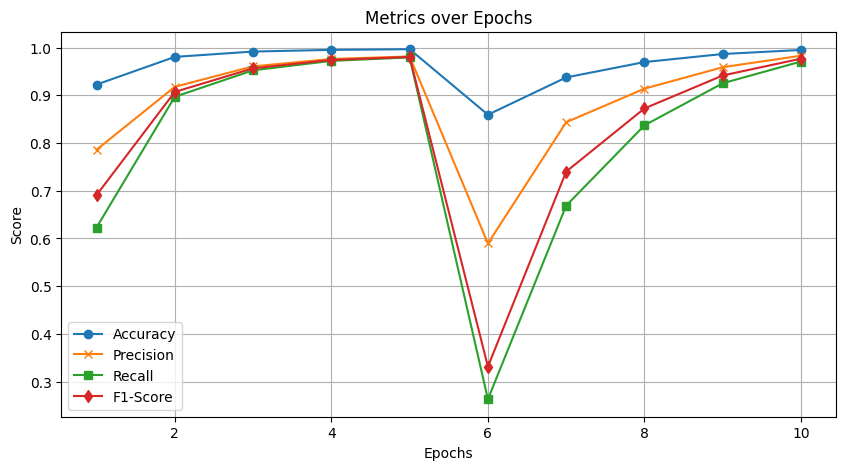

In [24]:
optimizer = AdamW(model.parameters(), lr=5e-5)

def train_model():
    model.train()
    for epoch in range(3):  # Number of epochs
        epoch_loss = 0
        all_preds, all_labels = [], []

        for batch in train_loader:
            inputs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()

            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            # print(f"Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Convert logits to predictions
            preds = torch.argmax(logits, dim=-1)

            # Collect predictions and true labels for evaluation, ignoring padded values
            for i in range(len(preds)):
                seq_len = (labels[i] != -100).sum().item()
                all_preds.extend(preds[i, :seq_len].cpu().numpy())
                all_labels.extend(labels[i, :seq_len].cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
        acc = accuracy_score(all_labels, all_preds)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}, '
              f'Accuracy: {acc:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1-Score: {f1:.4f}')
        # Plot loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot accuracy and metrics graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, marker='o', label='Accuracy')
    plt.plot(range(1, len(precision_values) + 1), precision_values, marker='x', label='Precision')
    plt.plot(range(1, len(recall_values) + 1), recall_values, marker='s', label='Recall')
    plt.plot(range(1, len(f1_values) + 1), f1_values, marker='d', label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

try:
    train_model()
except Exception as e:
    print(e)